# [Machine Learning with Core ML](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-core-ml)
**By:** Joshua Newnham (Author)  
**Publisher:** [Packt Publishing](https://www.packtpub.com/)

## Chapter 5 - Darknet 2 Keras 

In this notebook, we re-create the TinyYOLO network; details of the architecture can be found on the original [site](https://pjreddie.com/darknet/yolo/), specifically the associated [configuration file](https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-tiny-voc.cfg) of the TinyYOLO (trained on the dataset [VOC 2007+2012](http://host.robots.ox.ac.uk/pascal/VOC/)).

Once we have created the model, we will load in the [trained weights](https://pjreddie.com/media/files/yolov2-tiny-voc.weights) from Darknet version (available on their site). 


YOLO consists of a model and a set of algorithms to interpret the models outputs; this can be seen in the image below:  
<img src='https://pjreddie.com/media/image/model2.png' width='600px' /> 

The first and second illustrate the output of the model while the third (and last) illustrate the result of the algorithms applied to the outputs. 

The YOLO architecture allows for a single pass through the network (hence the name **You Only Look Once**); it achieves this by running the input (image) through a series of convolutional layers; it leverages the natural way CNNs split an image such that it treats the image as a set of grid cells. The output corresponds to each of the grid cells with an probability that an object exists along with the class, center position (x, y - relative to the grid cell) and size (w, h - also relative to the grid cell). You can see this visually in the figure above. 

The next phase is to run the predictions through **non-max supression** algorithm which, essentially, filters out objects that don't sufficiently meet a specified threshold and then filters out objects that are overlapped by other objects which have a higher confidence value.   

## Create model 

<img src='https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-with-Core-ML/master/Chapter05/Notebooks/Training/images/network.png' />

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    import numpy as np
    import pickle
    import os

    from keras.models  import Sequential, Model, load_model
    from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
    from keras.layers.advanced_activations import LeakyReLU
    from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
    from keras.optimizers import SGD, Adam, RMSprop
    from keras.layers.merge import concatenate

    import keras.backend as K
    from tqdm import tqdm

    import matplotlib.pyplot as plt
    %matplotlib inline

In [2]:
# load label 
LABELS = []

with open('data/voc2007_labels.txt', 'r') as f:    
    for line in f:
        LABELS.append(line.strip().lower())
                     
print('loaded {} labels'.format(len(LABELS)))

loaded 20 labels


In [ ]:
# Constants 

IMG_W, IMG_H = 416, 416
GRID_W, GRID_H = 13, 13
CHANNELS = 3

NUMBER_OF_CLASSES = len(LABELS)

# Bounding boxes; consisting of width x height pairs 
ANCHORS =  [1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52]
NUMBER_OF_ANCHOR_BOXES = 5

# Used to filter out uncertain predicted objects (calculated by joint 
# probability of their being a object present and the most likely class)  
OBJ_THRESHOLD    = 0.3 
# IOU threshold; anything larger than this (where  1 represents a perfect overlap and 
# 0 no overlap at all) will be ignored 
NMS_THRESHOLD    = 0.3 

In [4]:
def build_conv_block(idx=0, filters=16, 
                     add_pooling=True, pool_size=2, pool_stride=2, 
                     x=None):
    
    x = Conv2D(filters, (3,3), strides=(1,1), padding='same', 
               name='conv2d_{}'.format(idx), 
               use_bias=False)(x)
    
    x = BatchNormalization(name='batch_normalization_{}'.format(idx))(x)
    
    x = LeakyReLU(alpha=0.1, name='leaky_re_lu_{}'.format(idx))(x)
    
    if add_pooling:
        x = MaxPooling2D(pool_size=(2, 2), strides=(pool_stride,pool_stride), 
                         padding='same', 
                         name='max_pooling2d_{}'.format(idx))(x)
        
    return x

In [5]:
def build_model():    
    input_image = Input(shape=(IMG_H, IMG_W, CHANNELS), name='input_1')
    
    # Layer 1
    x = build_conv_block(1, filters=16, add_pooling=True, x=input_image)
    
    # Layer 2-5
    for idx, filters in enumerate([32, 64, 128, 256]):
        x = build_conv_block(idx + 2, filters=filters, add_pooling=True, x=x)
        
    # Layer 6
    x = build_conv_block(6, filters=512, add_pooling=True, pool_stride=1, x=x)
    
    # Layers 7-8 
    for idx, filters in enumerate([1024, 1024]):
        x = build_conv_block(idx + 7, filters=filters, add_pooling=False, x=x)
        
    # Layer 9 (Output layer) # NUMBER_OF_ANCHOR_BOXES * (1 + 4 + 20)
    output = Conv2D(NUMBER_OF_ANCHOR_BOXES * (1 + 4 + NUMBER_OF_CLASSES), (1,1), strides=(1,1), padding='same', 
                    name='conv2d_{}'.format(9), use_bias=True)(x)
    
    #output = Reshape((GRID_H, GRID_W, NUMBER_OF_ANCHOR_BOXES, 4 + 1 + NUMBER_OF_CLASSES))(output)
    
    model = Model(input_image, output)
    
    return model 

In [6]:
model = build_model()

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
__________

## Load pretrained weights
Load the weights originally provided by YOLO

In [8]:
from utils import WeightReader, decode_netout

In [9]:
WEIGHTS_PATH = 'data/yolov2-tiny-voc.weights'

In [10]:
weight_reader = WeightReader(WEIGHTS_PATH)

In [11]:
weight_reader.reset()
nb_conv = 9

for i in range(1, nb_conv+1):    
    conv_layer = model.get_layer('conv2d_{}'.format(i))    
    print("Setting weights for {}".format(conv_layer.name))
    
    if i < nb_conv:        
        norm_layer = model.get_layer('batch_normalization_{}'.format(i))
        print("Setting weights for {}".format(norm_layer.name))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
        
print("Finished setting weights")

Setting weights for conv2d_1
Setting weights for batch_normalization_1
Setting weights for conv2d_2
Setting weights for batch_normalization_2
Setting weights for conv2d_3
Setting weights for batch_normalization_3
Setting weights for conv2d_4
Setting weights for batch_normalization_4
Setting weights for conv2d_5
Setting weights for batch_normalization_5
Setting weights for conv2d_6
Setting weights for batch_normalization_6
Setting weights for conv2d_7
Setting weights for batch_normalization_7
Setting weights for conv2d_8
Setting weights for batch_normalization_8
Setting weights for conv2d_9
Finished setting weights


## Test 

In [12]:
from PIL import Image

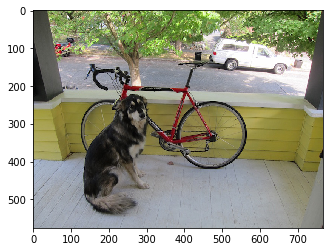

In [13]:
img = Image.open("images/dog.jpg")
plt.imshow(img)

transformed_dimensions [96, 0.0, 576, 576]


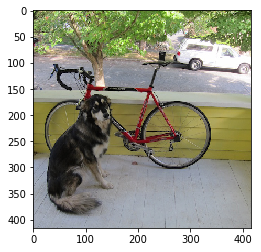

In [14]:
# Make it a square image 
if img.width > img.height:    
    ox = int((img.width - img.height)/2)
    oy = 0.0 
    cropped_img = img.crop((ox, 0, ox+img.height, img.height))
elif img.height > img.width:
    ox = 0.0 
    oy = int((img.height - img.width)/2)
    cropped_img = img.crop((0, oy, img.width, oy+img.width))
else:
    ox = 0.0 
    oy = 0.0 
    cropped_img = img.copy() 
    
# Store the offsets for later use (when we come to render the bounding boxes on the original image)
transformed_dimensions = [ox, oy, cropped_img.width, cropped_img.height]
    
# Resize it to the expected input size 
resized_img = cropped_img.resize((416, 416))

# Display image 
plt.imshow(resized_img)
print("transformed_dimensions {}".format(transformed_dimensions))

In [ ]:
# convert to numpy array 
x = np.array(resized_img)
# normalise  
x = x / 255. 
# add another dimension (expecting a batch) 
x = np.expand_dims(x, 0)

In [16]:
y = model.predict(x)[0]

## Interpret the results 

The image below illustrates the format of the output; where each anchor *block* consists of the bounding box (center x, center y, width, height) confidence and probability distribution for each class. The next step of functions/steps are used to interpret/parse these results to return a set of most likely bounding boxes with their associated (or likely) classes.    
<img src='images/model_output.png' width='500px' />

In [17]:
def boxes_iou(box1, box2): 
    """
    Calculates and returns the IoU (box1 and box2 interaction over their union)
    """
    # Get the Width and Height of each bounding box
    width_box1 = box1[2] 
    height_box1 = box1[3]
    width_box2 = box2[2]
    height_box2 = box2[3]
    
    # Calculate the area of the each bounding box
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # Find the vertical edges of the union of the two bounding boxes
    mx = min(box1[0] - width_box1/2.0, box2[0] - width_box2/2.0)
    Mx = max(box1[0] + width_box1/2.0, box2[0] + width_box2/2.0)
    
    # Calculate the width of the union of the two bounding boxes
    union_width = Mx - mx
    
    # Find the horizontal edges of the union of the two bounding boxes
    my = min(box1[1] - height_box1/2.0, box2[1] - height_box2/2.0)
    My = max(box1[1] + height_box1/2.0, box2[1] + height_box2/2.0)    
    
    # Calculate the height of the union of the two bounding boxes
    union_height = My - my
    
    # Calculate the width and height of the area of intersection of the two bounding boxes
    intersection_width = width_box1 + width_box2 - union_width
    intersection_height = height_box1 + height_box2 - union_height
   
    # If the the boxes don't overlap then their IOU is zero
    if intersection_width <= 0 or intersection_height <= 0:
        return 0.0

    # Calculate the area of intersection of the two bounding boxes
    intersection_area = intersection_width * intersection_height
    
    # Calculate the area of the union of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area
    
    # Calculate the IOU
    iou = intersection_area/union_area
    
    return iou

### Non-Maximal Suppression
The image below illustrates the general process of Non-Maximal Suppression, which is used to rank and filter the models output to those bounding boxes mostly likely. 

<img src='images/yolo_filtering.jpg' width='500px'/>

In [18]:
def nms(boxes, iou_thresh):
    """
    Implements the Non-Maximal Suppression algorithm as described in the paper 
    You Only Look Once: Unified, Real-Time Object Detection (https://arxiv.org/abs/1506.02640)
    """
    
    # If there are no bounding boxes do nothing
    if len(boxes) == 0:
        return boxes
    
    # Create a list of confidences to keep track of the detection confidence
    # of each predicted bounding box
    det_confs = np.array([box[4] for box in boxes])

    # Sort the indices of the bounding boxes by detection confidence value in descending order.
    sortIds = np.argsort(-det_confs)
    
    # Create an empty list to hold the best bounding boxes after
    # Non-Maximal Suppression (NMS) is performed
    best_boxes = []
    
    # Perform Non-Maximal Suppression 
    for i in range(len(boxes)):
        
        # Get the bounding box with the highest detection confidence first
        box_i = boxes[sortIds[i]]
        
        # Check that the detection confidence is not zero
        if box_i[4] > 0:
            
            # Save the bounding box 
            best_boxes.append(box_i)
            
            # Go through the rest of the bounding boxes in the list and calculate their IOU with
            # respect to the previous selected box_i. 
            for j in range(i + 1, len(boxes)):
                box_j = boxes[sortIds[j]]
                
                # If the IOU of box_i and box_j is higher than the given IOU threshold set
                # box_j's detection confidence to zero. 
                if boxes_iou(box_i, box_j) > iou_thresh:
                    box_j[4] = 0
                    
    return best_boxes

In [28]:
def detect_objects(ynet, 
                   nb_classes=NUMBER_OF_CLASSES, 
                   anchors=ANCHORS, 
                   nb_box=NUMBER_OF_ANCHOR_BOXES, 
                   obj_threshold=OBJ_THRESHOLD, 
                   nms_threshold=NMS_THRESHOLD):
    """
    :param y: Output from prediction 
    :param anchors: Dimensions of our boxes 
    :param nb_box: Number of anchor boxes for each grid 
    :param obj_threshold: Object detected threshold
    :param nms_threshold: Non-Maximal Suppression threshold 
    """
    print("detecting object Num anchors {}, object threshold {}, non-maximal suppression threshold {}".format(
        len(anchors)/2, obj_threshold, nms_threshold))
    
    import math    

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def softmax(x, axis=-1, t=-100.):
        x = x - np.max(x)        
        if np.min(x) < t:
            x = x/np.min(x)*t
        
        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)

    grid_h, grid_w = ynet.shape[:2]        
    
    # Each box is defined as 1 + 4 + NUMBER OF CLASSES
    stride = (1 + 4 + NUMBER_OF_CLASSES)           
    
    boxes = []
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):                     
                box_idx = b * stride
                grid_vec = ynet[row, col, box_idx:box_idx+stride] 
                
                # The 4th element is the confidence of a object being present 
                confidence = sigmoid(grid_vec[4])
                
                # From 5th element onwards are the classes 
                classes = softmax(grid_vec[5:])
                
                # Select the class with the largest confidence 
                cls_idx = np.argmax(classes)
                cls_score = classes[cls_idx]
                cls_confidence = cls_score * confidence                                
                                
                # Threshold confidence levels < obj_threshold 
                if cls_confidence < obj_threshold:
                    continue 
                    
                # Get the first 4 elements; which are x, y, w, and h (bounds 
                # of the detected object)
                tx, ty, tw, th = grid_vec[:4]
                
                cx = (col + sigmoid(tx)) / grid_w # center position, unit: image width
                cy = (row + sigmoid(ty)) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(tw) / grid_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(th) / grid_h # unit: image height                              
                
                bbox = [
                    cx, 
                    cy, 
                    w, 
                    h, 
                    cls_confidence, 
                    cls_idx
                ]
                
                boxes.append(bbox)
                
    # suppress non-maximal boxes
    boxes = nms(boxes, nms_threshold)
    
    return boxes                                     

In [29]:
boxes = detect_objects(y)

detecting object Num anchors 5, object threshold 0.3, non-maximal suppression threshold 0.3


In [30]:
def draw_boxes(org_img, resized_shape, boxes, labels):
    """
    :param org_img: 
    :param resized_shape: (ox, oy, img width, img height )
    :param boxes: array of [x, y, w, h, confidence, class index]
    :param labels: 
    """
    from PIL import Image, ImageFont, ImageDraw, ImageEnhance
    
    # Create a copy 
    img = org_img.copy() 
    
    draw = ImageDraw.Draw(img)
    
    for bbox in boxes:
        w = bbox[2] * resized_shape[2]
        h = bbox[3] * resized_shape[3]        
        x = resized_shape[0] + ((bbox[0] * resized_shape[2])) - w/2
        y = resized_shape[1] + ((bbox[1] * resized_shape[3])) - h/2
        
        draw.rectangle(((x, y), (x + w, y + h)), outline="black")
        draw.text((x + w/2, y + h + 5), labels[bbox[5]], anchor='middle')
            
    return img

In [31]:
transformed_dimensions

[96, 0.0, 576, 576]

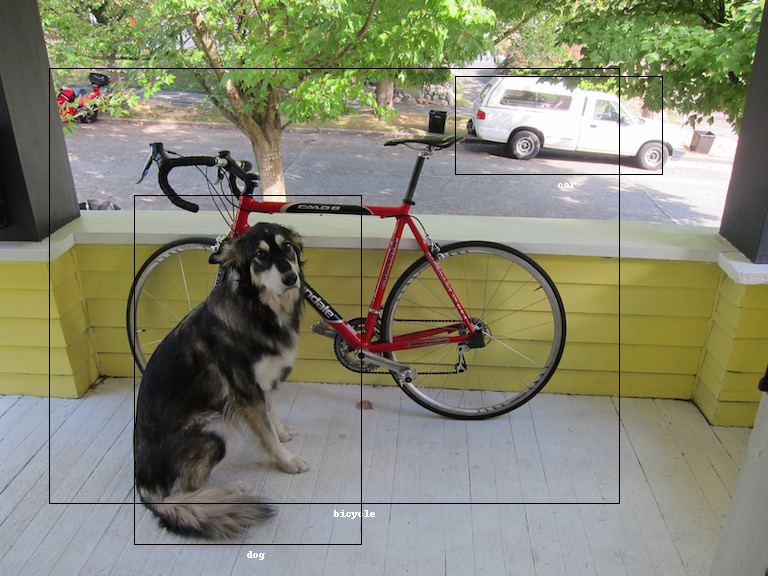

In [32]:
draw_boxes(img, transformed_dimensions, boxes, LABELS)

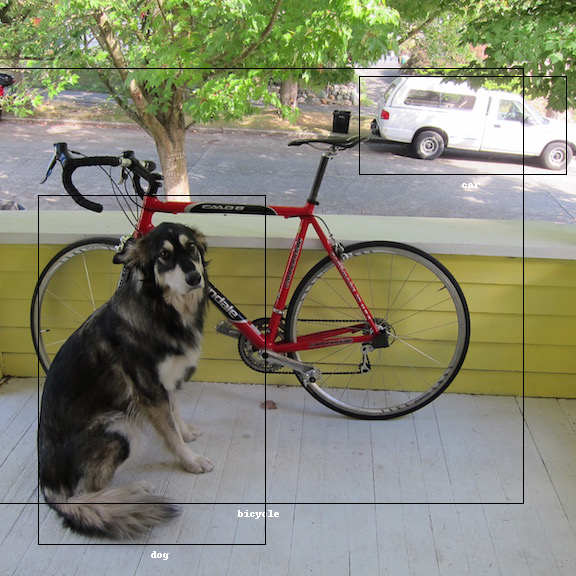

In [33]:
draw_boxes(cropped_img, [0, 0, cropped_img.width, cropped_img.height], boxes, LABELS)

## Save model 

In [45]:
model.save('output/tinyyolo_voc2007_modelweights.h5')